In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import pickle  # For model deployment

In [2]:
# Step 2: Load the dataset
# Replace 'healthcare_data.csv' with your dataset
data = pd.read_csv(r'C:\Users\theba\OneDrive\Desktop\Projects\Project 3 Analyzing Personalize Healthcare Recommandation\blood.csv')

In [9]:
# Step 3: Data exploration and visualization
# Basic information and statistics
print("Dataset Info:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Recency    748 non-null    int64
 1   Frequency  748 non-null    int64
 2   Monetary   748 non-null    int64
 3   Time       748 non-null    int64
 4   Class      748 non-null    int64
dtypes: int64(5)
memory usage: 29.3 KB
None

Summary Statistics:
          Recency   Frequency      Monetary        Time       Class
count  748.000000  748.000000    748.000000  748.000000  748.000000
mean     9.506684    5.516043   1378.676471   34.284759    0.237968
std      8.095396    5.841825   1459.826781   24.380307    0.426124
min      0.000000    1.000000    250.000000    2.000000    0.000000
25%      2.750000    2.000000    500.000000   16.000000    0.000000
50%      7.000000    4.000000   1000.000000   28.000000    0.000000
75%     14.000000    7.000000   1750.000000   50.000000    0.000000
max    

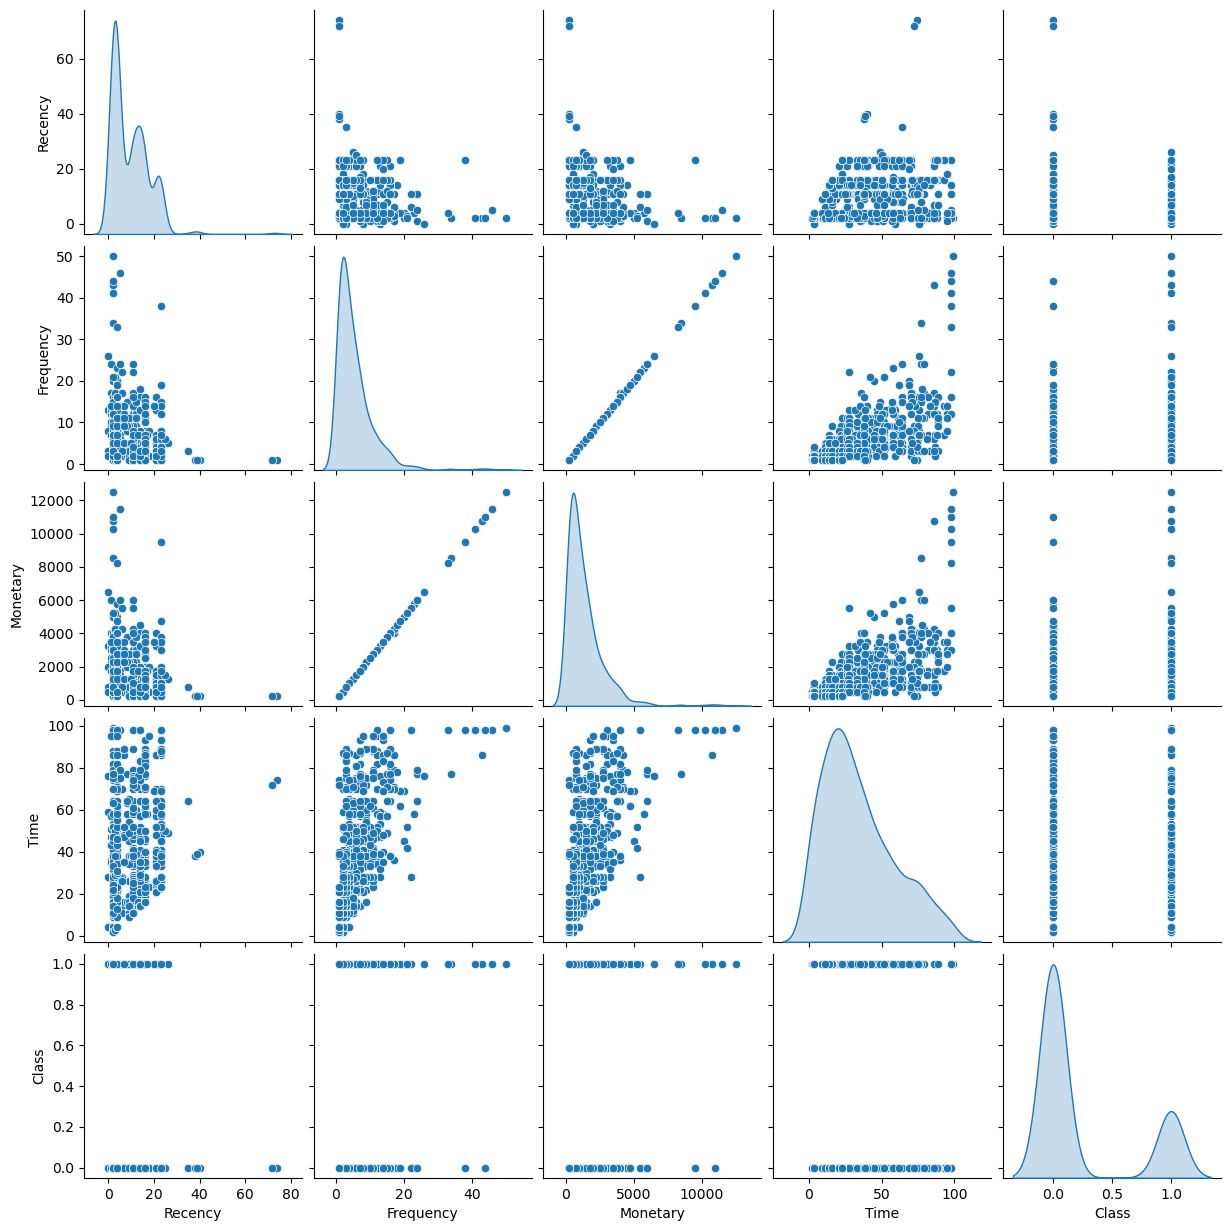

In [11]:
# Visualize relationships and distributions
sns.pairplot(data, diag_kind='kde')
plt.show()



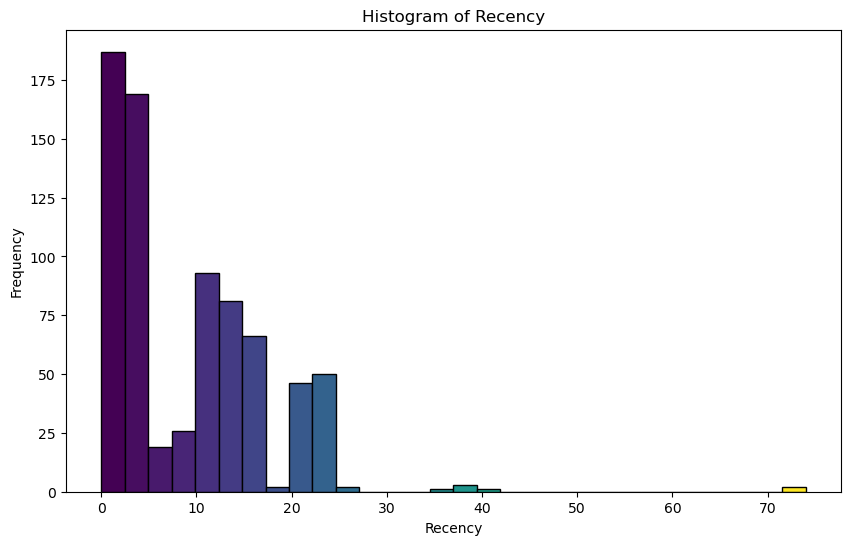

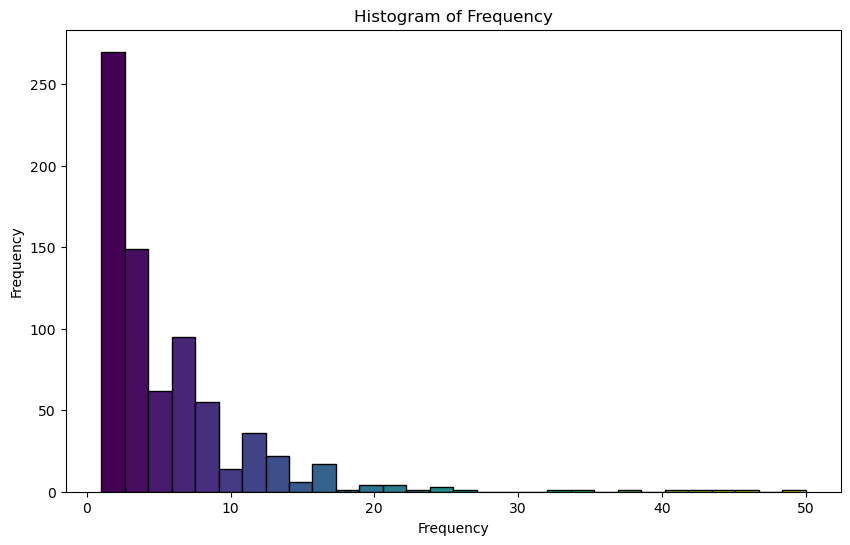

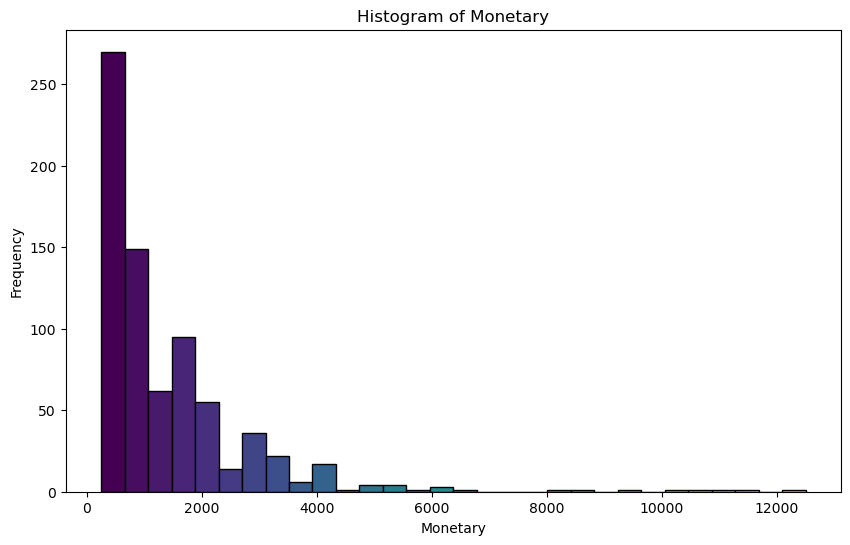

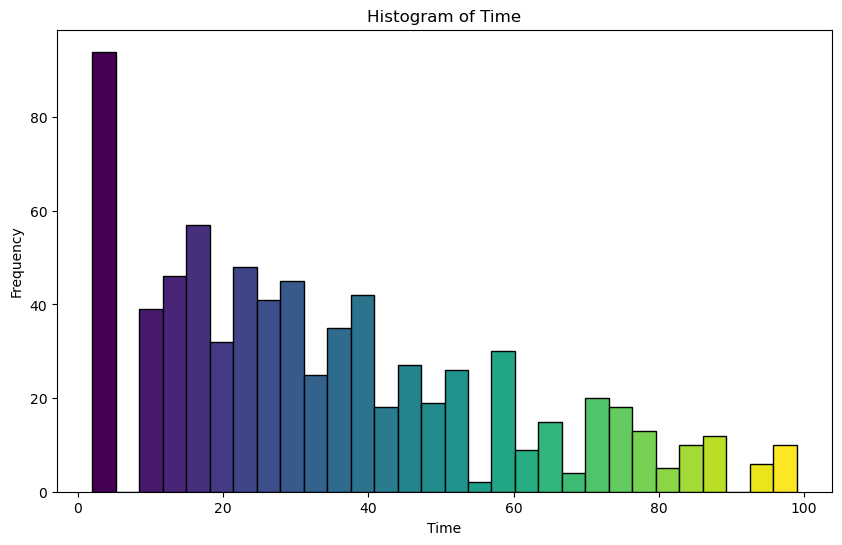

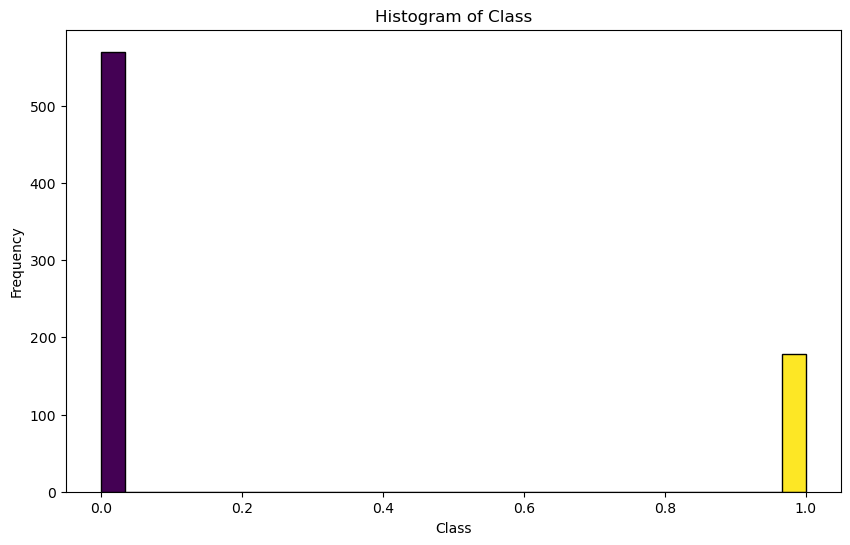

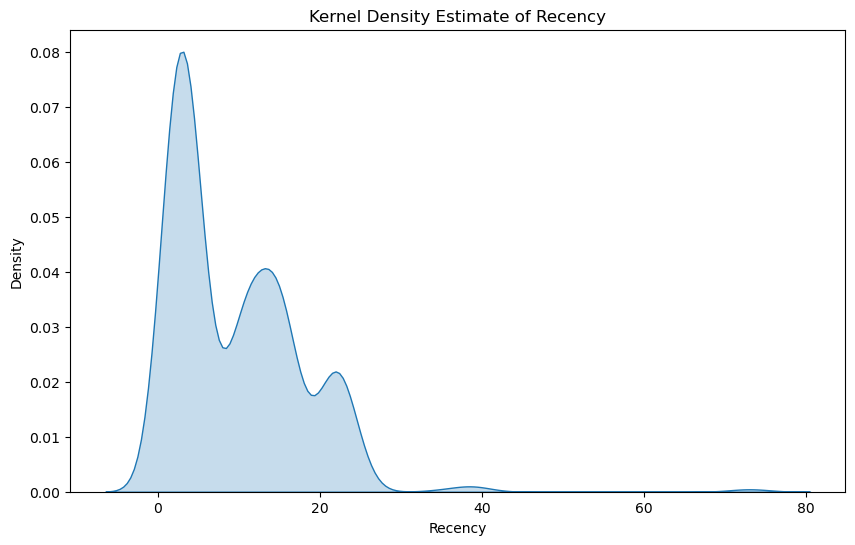

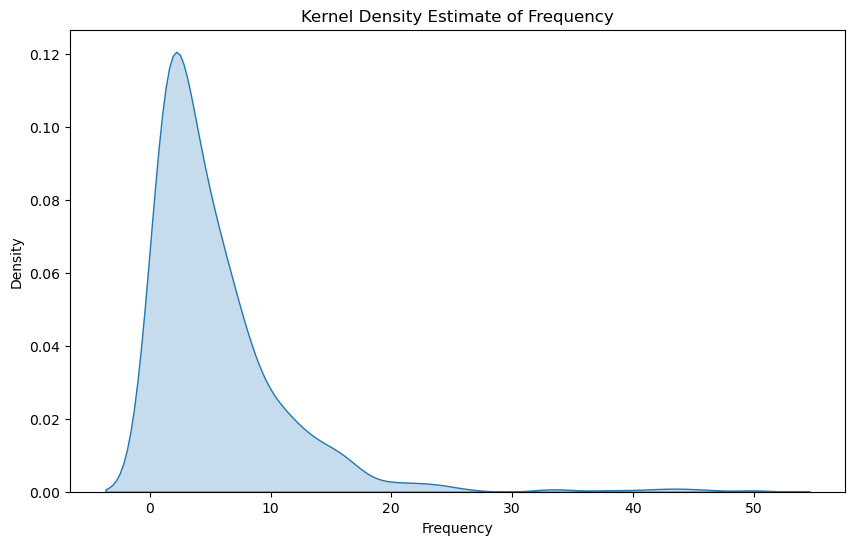

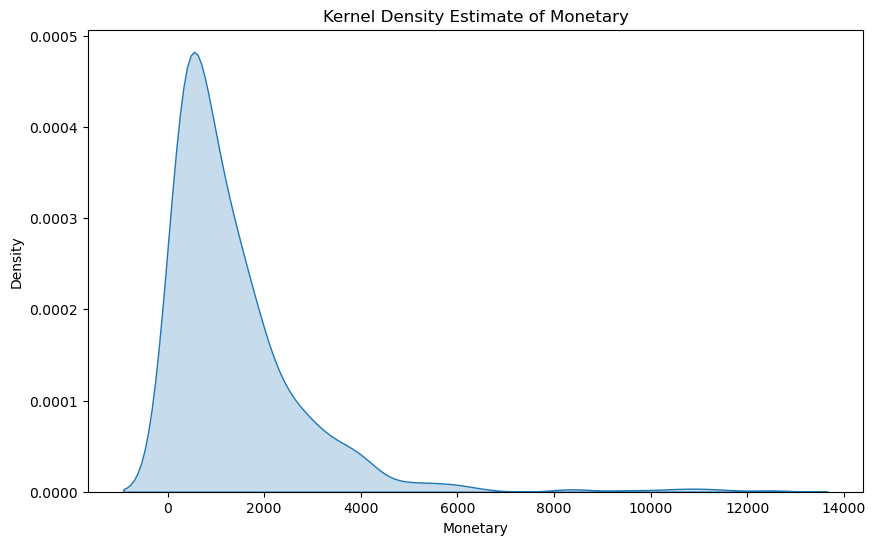

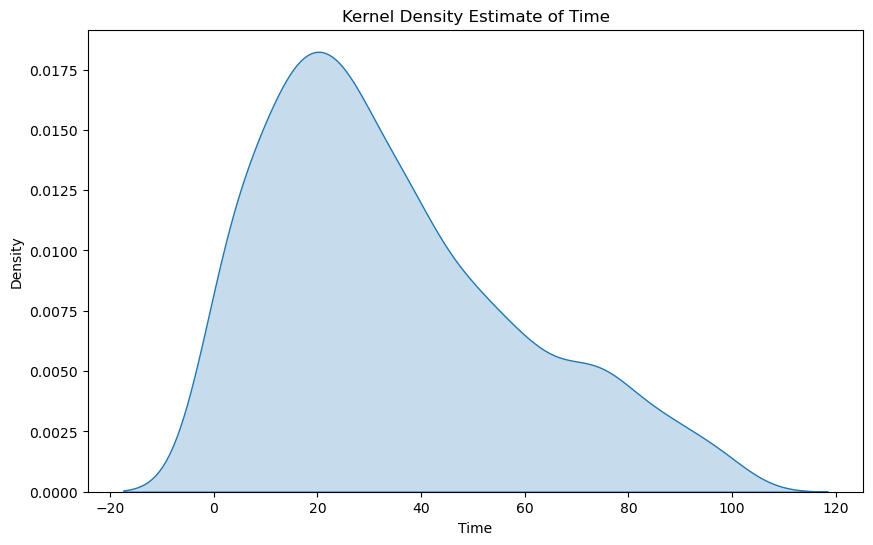

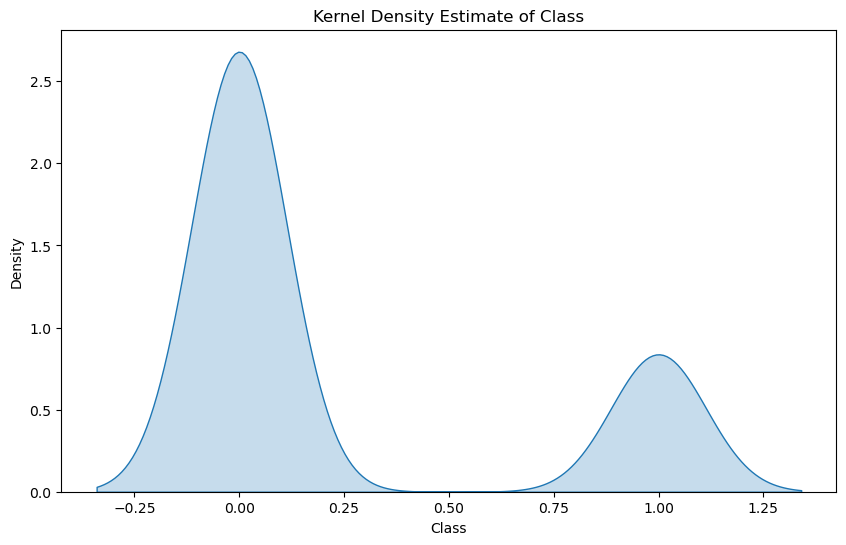

In [42]:
# Histograms with multicolored bars
for column in data.columns:
    plt.figure(figsize=(10, 6))
    values = data[column].values
    counts, bins, patches = plt.hist(values, bins=30, edgecolor='black')  # Define the number of bins
    colors = plt.cm.viridis(np.linspace(0, 1, len(patches)))  # Choose a color map

    # Color each bar
    for patch, color in zip(patches, colors):
        patch.set_facecolor(color)
    
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# Kernel Density Estimates with 'fill' parameter
for column in data.columns:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data[column], fill=True)
    plt.title(f'Kernel Density Estimate of {column}')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()


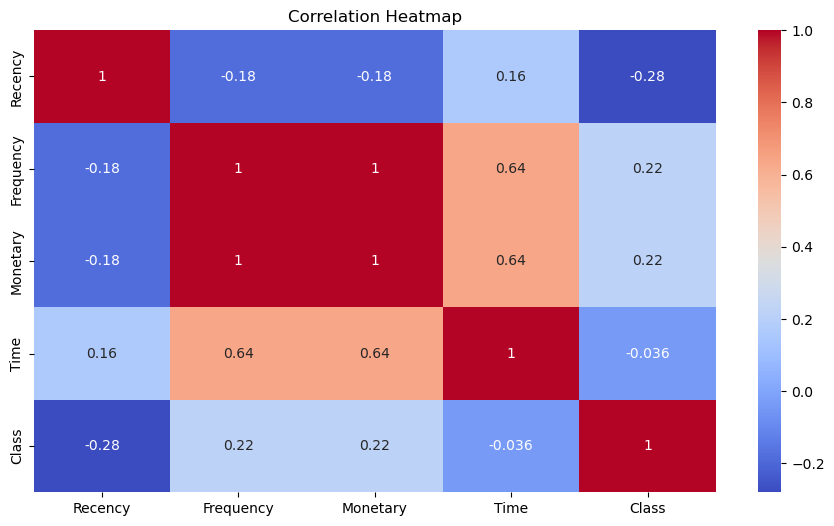

In [43]:
# Correlation heatmap
plt.figure(figsize=(11, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


In [13]:
# Step 4: Data Preprocessing
# Separate features and target variable
X = data.drop('Class', axis=1)  # Target column is 'Class'
y = data['Class']

# Identify numerical and categorical features
numerical_features = ['Recency', 'Frequency', 'Monetary', 'Time']  # Adjust as necessary
categorical_features = []  # If no categorical features, leave as empty list

# Create pipelines for preprocessing
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

if categorical_features:
    categorical_pipeline = Pipeline(steps=[
        ('encoder', OneHotEncoder(drop='first'))
    ])
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])
else:
    preprocessor = ColumnTransformer(transformers=[
        ('num', numerical_pipeline, numerical_features)
    ])

In [14]:
# Step 5: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Step 6: Model Selection and Training
# Create a model pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Save the trained model for deployment
with open('healthcare_model.pkl', 'wb') as file:
    pickle.dump(model_pipeline, file)


Confusion Matrix:
[[100  13]
 [ 28   9]]

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       113
           1       0.41      0.24      0.31        37

    accuracy                           0.73       150
   macro avg       0.60      0.56      0.57       150
weighted avg       0.69      0.73      0.70       150



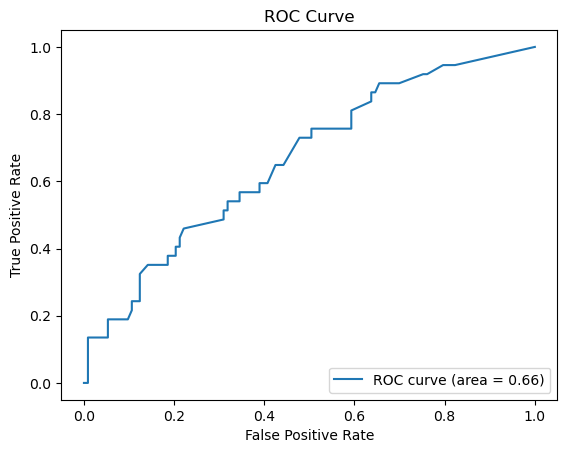

In [16]:
# Step 7: Model Evaluation
# Make predictions
y_pred = model_pipeline.predict(X_test)

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Curve
if len(np.unique(y)) == 2:  # Binary classification check
    y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=model_pipeline.named_steps['classifier'].classes_[1])
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc_score(y_test, y_pred_proba)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

In [17]:
# Step 8: Recommendation System Implementation
def generate_recommendations(patient_data):
    # Predict the category
    prediction = model_pipeline.predict(patient_data)
    recommendation_mapping = {
        0: 'No action needed',
        1: 'Regular check-up required'
    }
    return recommendation_mapping.get(prediction[0], "Recommendation unavailable")

# Example: Generate recommendations for a new patient
example_patient_data = pd.DataFrame({
    'Recency': [10],
    'Frequency': [5],
    'Monetary': [1500],
    'Time': [30]
})

print("\nPersonalized Recommendation:")
print(generate_recommendations(example_patient_data))


Personalized Recommendation:
No action needed


In [18]:
# Step 9: Deployment
# Use Flask for deployment (code snippet for Flask app)
'''
from flask import Flask, request, jsonify
import pickle
import pandas as pd

app = Flask(__name__)

# Load the saved model
with open('healthcare_model.pkl', 'rb') as file:
    model = pickle.load(file)

@app.route('/predict', methods=['POST'])
def predict():
    # Get JSON data
    data = request.get_json()
    patient_data = pd.DataFrame(data)
    recommendation = generate_recommendations(patient_data)
    return jsonify({'recommendation': recommendation})

if __name__ == '__main__':
    app.run(debug=True)
'''

"\nfrom flask import Flask, request, jsonify\nimport pickle\nimport pandas as pd\n\napp = Flask(__name__)\n\n# Load the saved model\nwith open('healthcare_model.pkl', 'rb') as file:\n    model = pickle.load(file)\n\n@app.route('/predict', methods=['POST'])\ndef predict():\n    # Get JSON data\n    data = request.get_json()\n    patient_data = pd.DataFrame(data)\n    recommendation = generate_recommendations(patient_data)\n    return jsonify({'recommendation': recommendation})\n\nif __name__ == '__main__':\n    app.run(debug=True)\n"